<class 'numpy.ndarray'>
(854, 1280, 3)
[ 0 33 50]


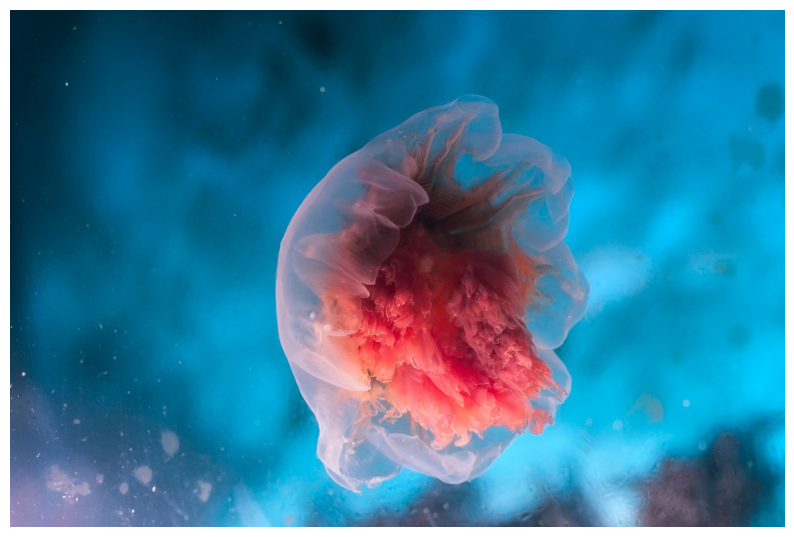

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
import os
import ctypes
import numpy as np


glitch_lib_path = "bin/krlnk_image_fft_glitch.so"
image_fft_glitch = ctypes.CDLL(glitch_lib_path)
image_fft_glitch.image_fft_glitch.argtypes = [
    ctypes.POINTER(ctypes.c_double),  # image
    ctypes.c_int,                     # image_arr_size
    ctypes.c_int,                     # chunk_size
    ctypes.c_int,                     # quantization_levels
    ctypes.POINTER(ctypes.c_double),  # real_hist
    ctypes.c_int,                     # real_hist_len
    ctypes.POINTER(ctypes.c_double),  # imag_hist
    ctypes.c_int                      # imag_hist_len
]

test_data_dir = "test_data"
test_image_files = [x for x in os.listdir(test_data_dir) if x.endswith(".jpg")]
image_name = "test_10.jpg"
image_path = os.path.join(test_data_dir, image_name)
image = io.imread(image_path)

print(type(image))
print(image.shape)
print(image[0][0])

def show_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

show_image(image)
chunk_size = image.shape[1]

In [8]:
red_channel = image[:, :, 0].flatten()
blue_channel = image[:, :, 1].flatten()
green_channel = image[:, :, 2].flatten()

red_channel_c_array = (ctypes.c_double * len(red_channel))(*red_channel)
blue_channel_c_array = (ctypes.c_double * len(blue_channel))(*blue_channel)
green_channel_c_array = (ctypes.c_double * len(green_channel))(*green_channel)

quantization_levels = 16

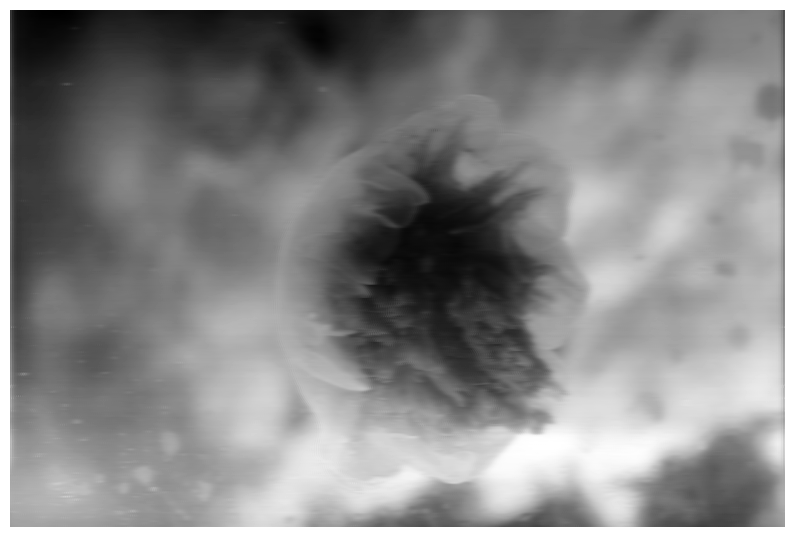

In [9]:
def play_with_isolated_channel(channel_c_arr):
    real_hist_test = [1.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    imag_hist_test = real_hist_test.copy()

    real_hist_c_array = (ctypes.c_double * len(real_hist_test))(*real_hist_test)
    imag_hist_c_array = (ctypes.c_double * len(imag_hist_test))(*imag_hist_test)

    image_fft_glitch.image_fft_glitch(
        channel_c_arr,
        len(red_channel),
        chunk_size,
        quantization_levels,
        real_hist_c_array,
        len(real_hist_test),
        imag_hist_c_array,
        len(imag_hist_test)
    )

    # Convert ctypes array back to NumPy arrays
    channel_numpy = np.ctypeslib.as_array(channel_c_arr)
    # Reshape to original 2D shape
    reshaped_arr = channel_numpy.reshape(image[:, :, 0].shape)

    show_image(reshaped_arr)

play_with_isolated_channel(green_channel_c_array)

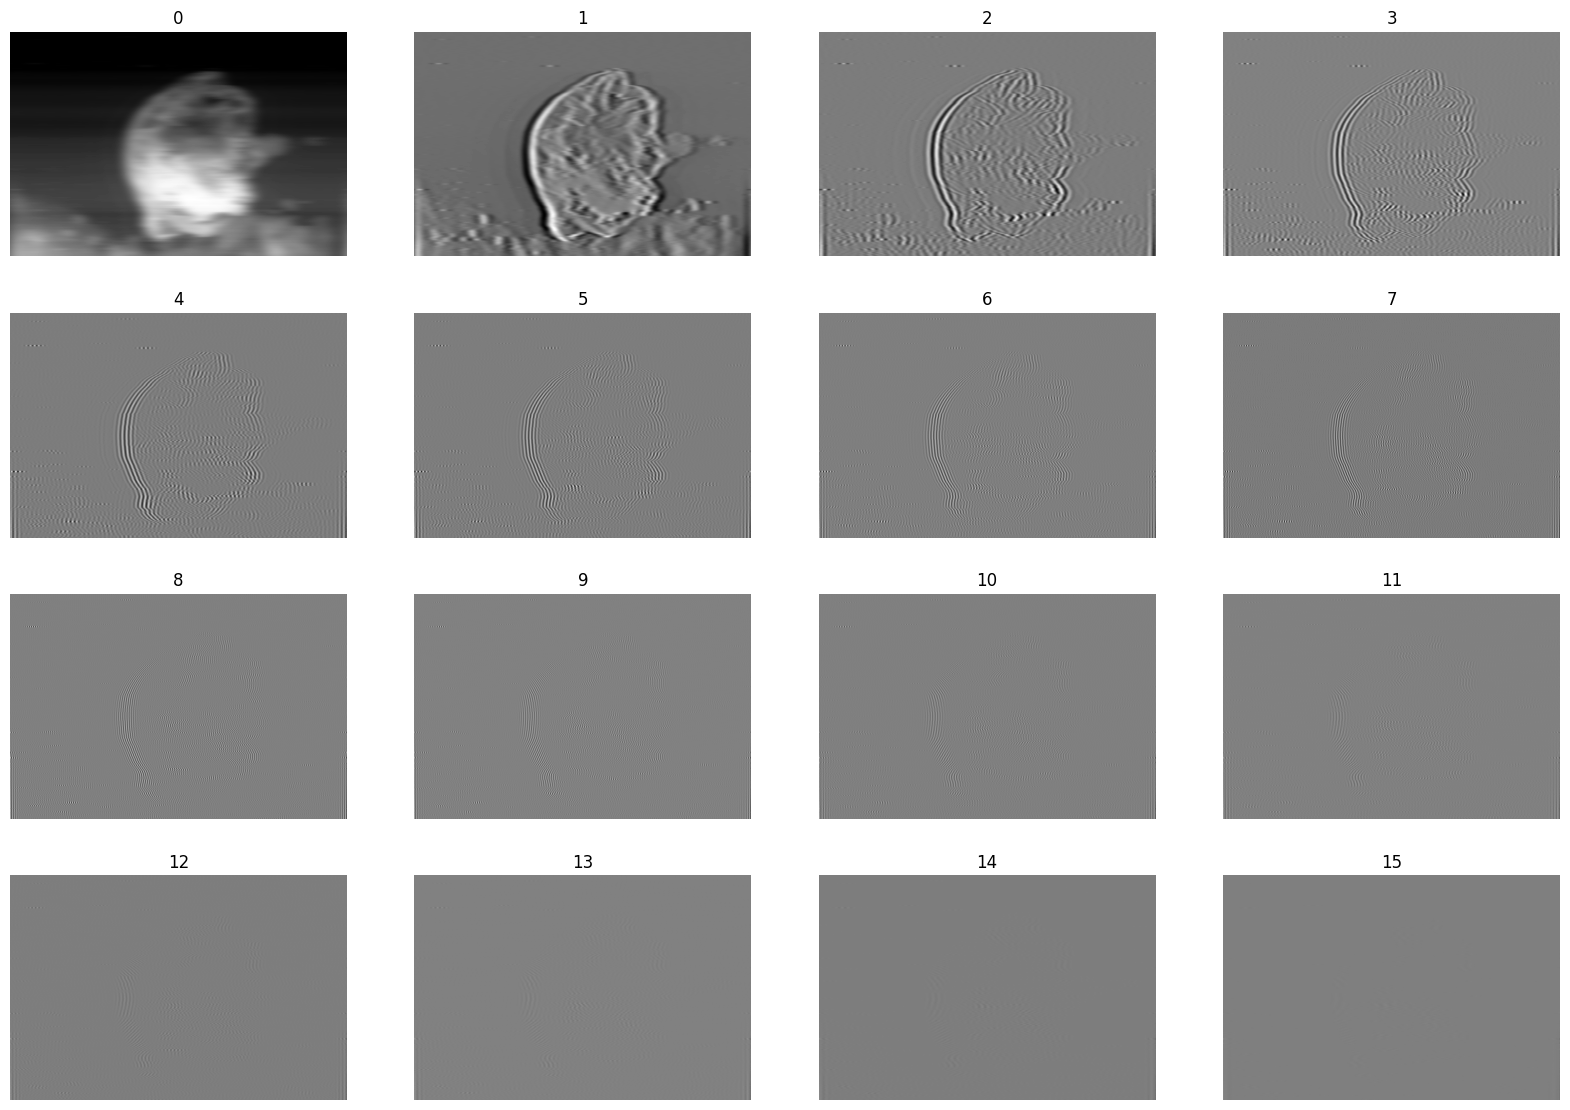

In [10]:
def try_diff_isolates(channel_arr):
    plt.figure(figsize=(20, 14))

    for i in range(16):
        working_channel_np = channel_arr.copy()
        working_channel = (ctypes.c_double * len(working_channel_np))(*working_channel_np)
        real_hist_test = [0.0] * 64
        real_hist_test[i] = 1.5
        imag_hist_test = real_hist_test.copy()
        # imag_hist_test = [1.0, 0.0]

        real_hist_c_array = (ctypes.c_double * len(real_hist_test))(*real_hist_test)
        imag_hist_c_array = (ctypes.c_double * len(imag_hist_test))(*imag_hist_test)

        image_fft_glitch.image_fft_glitch(
            working_channel,
            len(red_channel),
            chunk_size,
            quantization_levels,
            real_hist_c_array,
            len(real_hist_test),
            imag_hist_c_array,
            len(imag_hist_test)
        )

        channel_numpy = np.ctypeslib.as_array(working_channel)
        reshaped_arr = channel_numpy.reshape(image[:, :, 0].shape)

        plt.subplot(4, 4, i+1)
        plt.title(i)
        plt.imshow(reshaped_arr, cmap='gray')
        plt.axis('off')

    plt.show()

try_diff_isolates(red_channel)


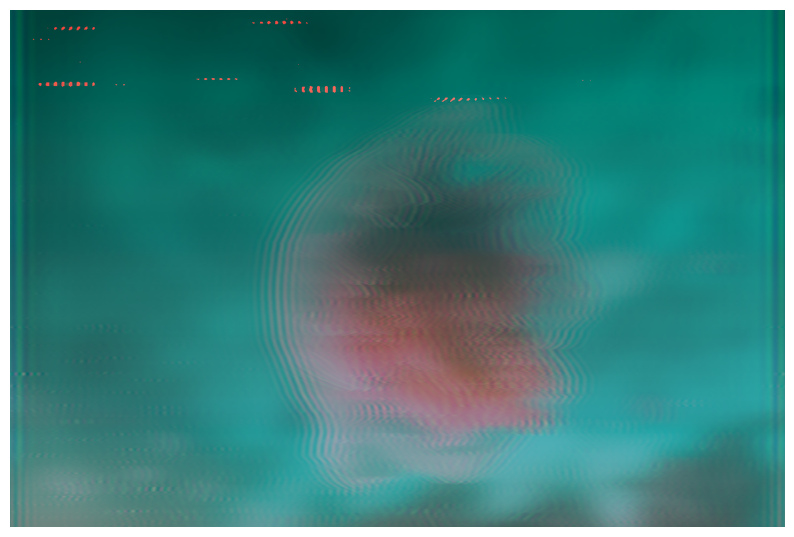

In [23]:
red_channel = image[:, :, 0].flatten()
blue_channel = image[:, :, 1].flatten()
green_channel = image[:, :, 2].flatten()


def process_a_channel(channel_arr, real_hist, imag_hist):
    channel_c_arr = (ctypes.c_double * len(channel_arr))(*channel_arr)
    real_hist_c_array = (ctypes.c_double * len(real_hist))(*real_hist)
    imag_hist_c_array = (ctypes.c_double * len(imag_hist))(*imag_hist)

    image_fft_glitch.image_fft_glitch(
        channel_c_arr,
        len(red_channel),
        chunk_size,
        quantization_levels,
        real_hist_c_array,
        len(real_hist),
        imag_hist_c_array,
        len(real_hist)
    )

    # Convert ctypes array back to NumPy arrays
    channel_numpy = np.ctypeslib.as_array(channel_c_arr)
    # Reshape to original 2D shape
    reshaped_arr = channel_numpy.reshape(image[:, :, 0].shape)

    return reshaped_arr


red_filter = [0.0 for _ in range(64)]
red_filter[0] = 1
red_filter[5] = 5

green_filter = [0.0 for _ in range(64)]
green_filter[0] = 0.8
green_filter[3] = 2

blue_filter = [0.0 for _ in range(64)]
blue_filter[0] = 1
blue_filter[5] = 1

processed_red = process_a_channel(
    red_channel,
    red_filter,
    red_filter,
)
processed_green = process_a_channel(
    green_channel,
    green_filter,
    green_filter,
)
processed_blue = process_a_channel(
    blue_channel,
    blue_filter,
    blue_filter,
)

glitched_img = np.stack([processed_red, processed_green, processed_blue], axis=2).astype(np.uint8)
show_image(glitched_img)

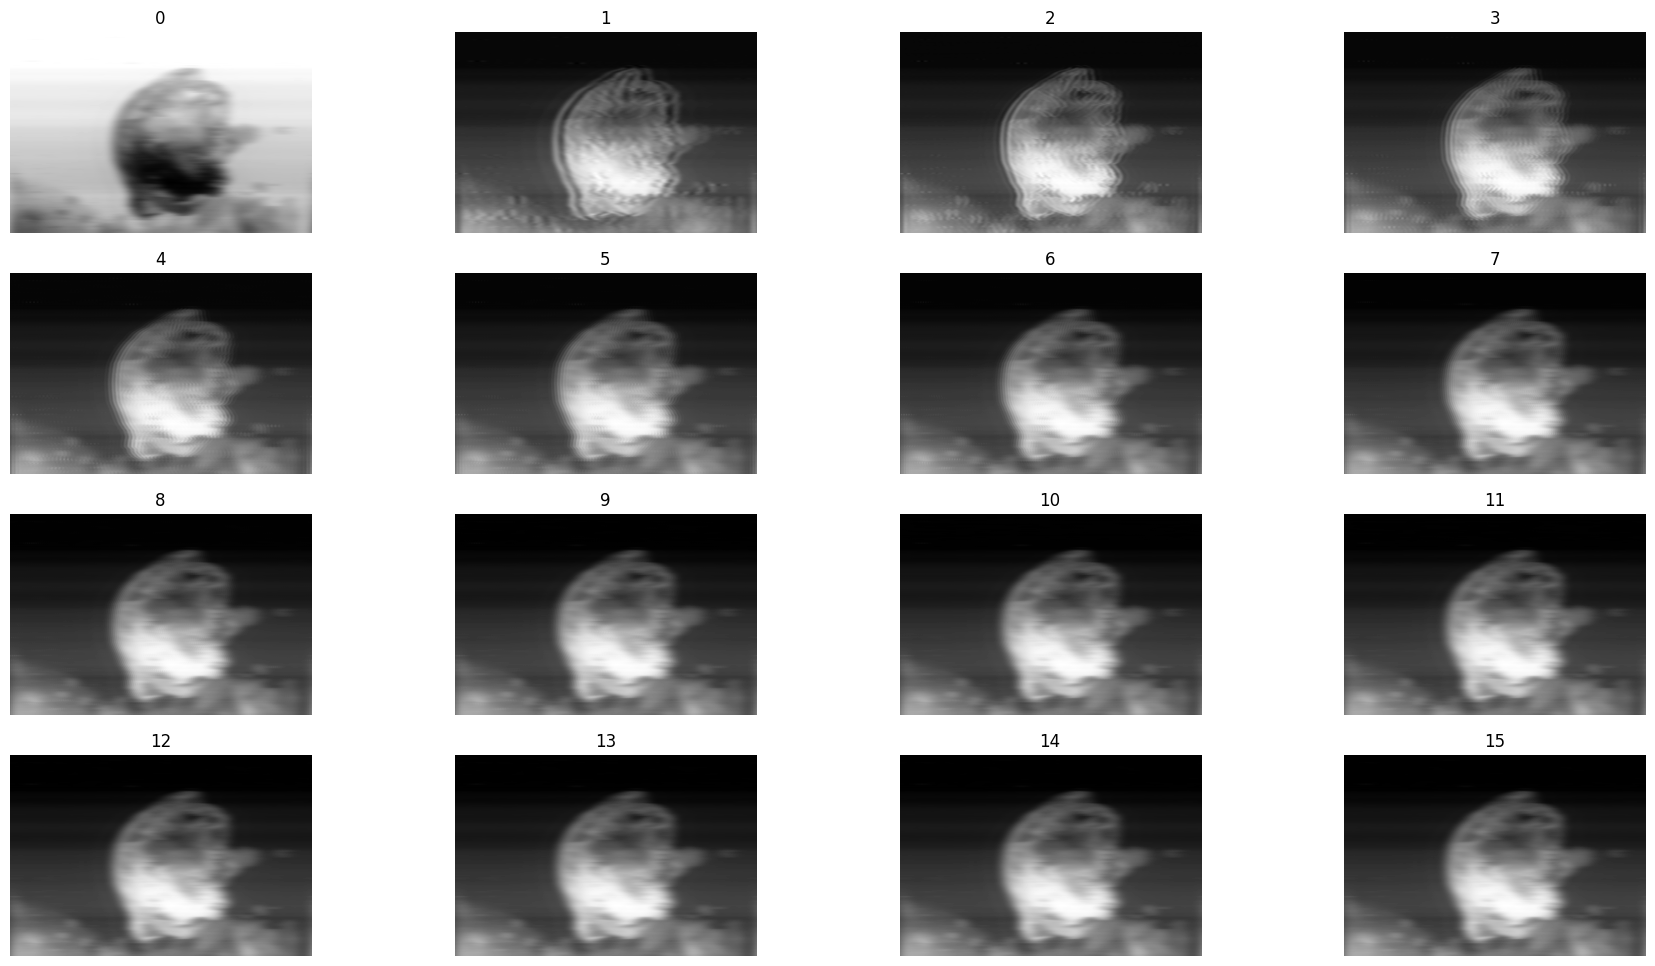

In [15]:
def try_diff_isolates(channel_arr):
    plt.figure(figsize=(22, 12))

    for i in range(16):
        working_channel_np = channel_arr.copy()
        working_channel = (ctypes.c_double * len(working_channel_np))(*working_channel_np)
        real_hist_test = [0.0] * 64
        # imag_hist_test = [0.0] * 46
        real_hist_test[0] = 1.0
        real_hist_test[i] = -1.0
        # imag_hist_test[0] = 1.0
        # imag_hist_test[i + 1] = 1.0
        imag_hist_test = real_hist_test.copy()
        # imag_hist_test = [1.0, 0.0]

        real_hist_c_array = (ctypes.c_double * len(real_hist_test))(*real_hist_test)
        imag_hist_c_array = (ctypes.c_double * len(imag_hist_test))(*imag_hist_test)

        image_fft_glitch.image_fft_glitch(
            working_channel,
            len(red_channel),
            chunk_size,
            quantization_levels,
            real_hist_c_array,
            len(real_hist_test),
            imag_hist_c_array,
            len(imag_hist_test)
        )

        channel_numpy = np.ctypeslib.as_array(working_channel)
        reshaped_arr = channel_numpy.reshape(image[:, :, 0].shape)

        plt.subplot(4, 4, i+1)
        plt.title(i)
        plt.imshow(reshaped_arr, cmap='gray')
        plt.axis('off')

    plt.show()

try_diff_isolates(red_channel)
